In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz  # Import the trapz function
from scipy.signal import savgol_filter



In [2]:
# Load the pixel reflectance data
# Skip the header row and remove extra quotation marks
file_path = 'kaolinite_pixel.csv'


# Convert to a pandas DataFrame
pixel_data = pd.read_csv(file_path)
pixel_data.head()


pixel_data['wavelength'] = pixel_data['wavelength'] / 1000 




In [3]:
# Print the original data
print("Original Pixel Data:")
print(pixel_data.head())

# Reset the indices
pixel_data = pixel_data.reset_index(drop=True)


Original Pixel Data:
   wavelength  reflectance
0    1.353042          1.0
1    1.358051          1.0
2    1.363060          1.0
3    1.368068          1.0
4    1.373077          1.0


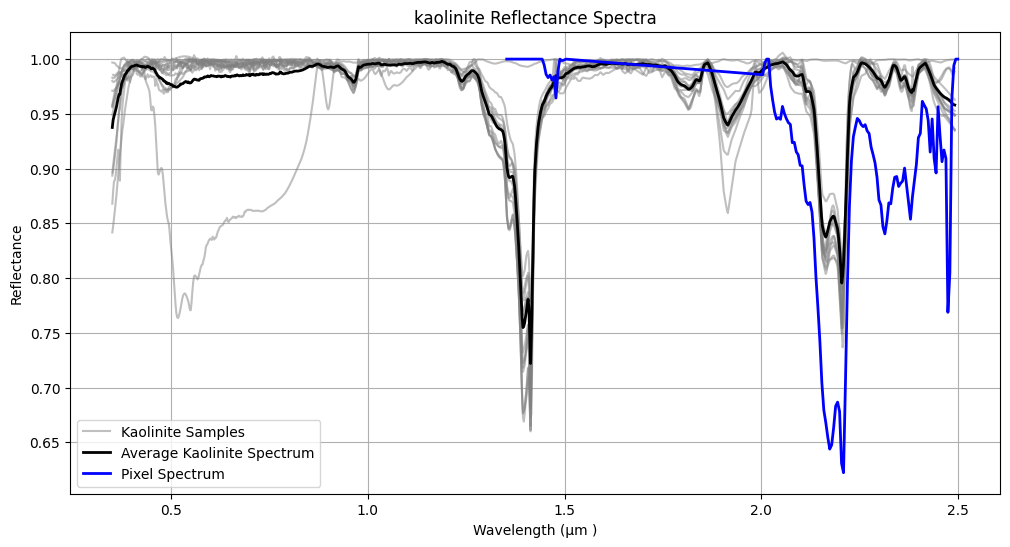

In [4]:
# Load the interpolated reflectance values for the 13 kaolinite samples
kaolinite_data = pd.read_csv('interpolated_reflectance_kaolinite.csv')


# Calculate the average reflectance spectrum
kaolinite_data['average_reflectance'] = kaolinite_data.filter(like='reflectance').mean(axis=1)

# Plot all 13 illite reflectance spectra in light colors
plt.figure(figsize=(12, 6))
for i in range(1, 14):  # Assuming columns are named reflectance_1 to reflectance_13
    plt.plot(kaolinite_data['wavelength'], kaolinite_data[f'reflectance_{i}'], color='gray', alpha=0.5, label=f'Kaolinite Samples' if i == 1 else "")

#Plot the average reflectance spectrum in bold black
plt.plot(kaolinite_data['wavelength'], kaolinite_data['average_reflectance'], color='black', linewidth=2, label='Average Kaolinite Spectrum')

# Plot the pixel reflectance spectrum in blue
plt.plot(pixel_data['wavelength'], pixel_data['reflectance'], color='blue', linewidth=2, label='Pixel Spectrum')
# Add labels and legend
plt.xlabel('Wavelength (µm )')
plt.ylabel('Reflectance')
plt.title('kaolinite Reflectance Spectra')
plt.legend()
plt.grid()
plt.show()


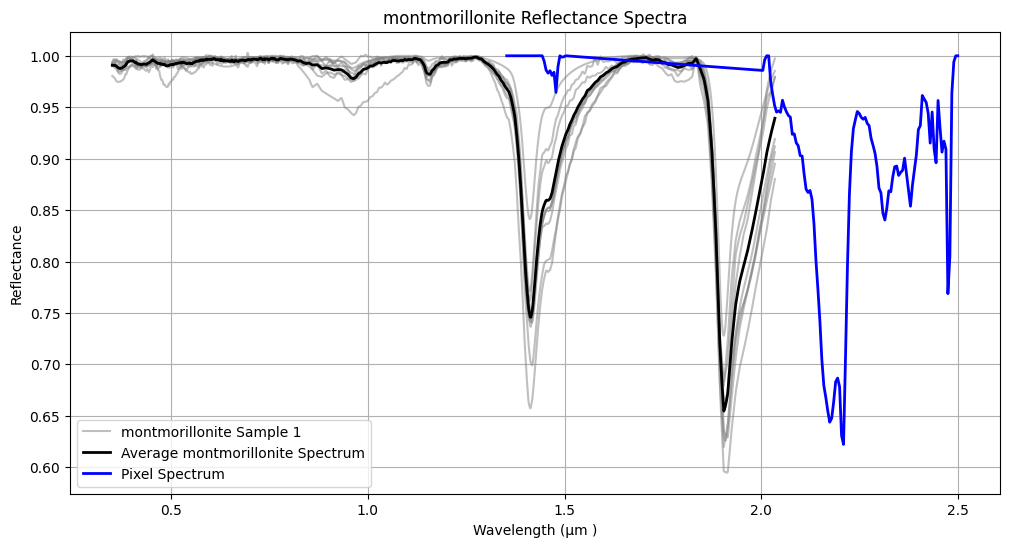

In [5]:
# Load the interpolated reflectance values for the 9 montmorillonite samples
montmorillonite_data = pd.read_csv('interpolated_reflectance_montmorillonite.csv')


# Calculate the average reflectance spectrum
montmorillonite_data['average_reflectance'] = montmorillonite_data.filter(like='reflectance').mean(axis=1)

# Plot all 13 illite reflectance spectra in light colors
plt.figure(figsize=(12, 6))
for i in range(1, 10):  # Assuming columns are named reflectance_1 to reflectance_9
    plt.plot(montmorillonite_data['wavelength'], montmorillonite_data[f'reflectance_{i}'], color='gray', alpha=0.5, label=f'montmorillonite Sample {i}' if i == 1 else "")

#Plot the average reflectance spectrum in bold black
plt.plot(montmorillonite_data['wavelength'], montmorillonite_data['average_reflectance'], color='black', linewidth=2, label='Average montmorillonite Spectrum')

# Plot the pixel reflectance spectrum in blue
plt.plot(pixel_data['wavelength'], pixel_data['reflectance'], color='blue', linewidth=2, label='Pixel Spectrum')
# Add labels and legend
plt.xlabel('Wavelength (µm )')
plt.ylabel('Reflectance')
plt.title('montmorillonite Reflectance Spectra')
plt.legend()
plt.grid()
plt.show()

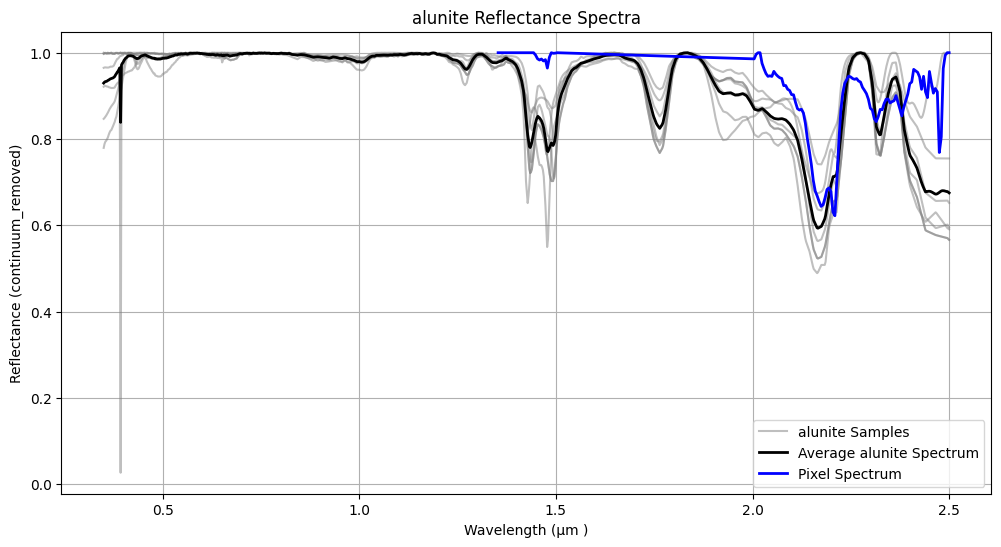

In [20]:
# Load the interpolated reflectance values for the 13 kaolinite samples
alunite_data = pd.read_csv('interpolated_reflectance_alunite.csv')


# Calculate the average reflectance spectrum
alunite_data['average_reflectance'] = alunite_data.filter(like='reflectance').mean(axis=1)

# Plot all 13 illite reflectance spectra in light colors
plt.figure(figsize=(12, 6))
for i in range(1, 8):  # Assuming columns are named reflectance_1 to reflectance_13
    plt.plot(alunite_data['wavelength'], alunite_data[f'reflectance_{i}'], color='gray', alpha=0.5, label=f'alunite Samples' if i == 1 else "")

#Plot the average reflectance spectrum in bold black
plt.plot(alunite_data['wavelength'], alunite_data['average_reflectance'], color='black', linewidth=2, label='Average alunite Spectrum')

# Plot the pixel reflectance spectrum in blue
plt.plot(pixel_data['wavelength'], pixel_data['reflectance'], color='blue', linewidth=2, label='Pixel Spectrum')
# Add labels and legend
plt.xlabel('Wavelength (µm )')
plt.ylabel('Reflectance (continuum_removed)')
plt.title('alunite Reflectance Spectra')
plt.legend()
plt.grid()
plt.show()


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def extract_spectral_features(csv_path, min_peak_depth=0.05):
    # Load continuum-removed reflectance data
    df = pd.read_csv(csv_path)

    # Convert to numeric
    df['wavelength'] = df['wavelength'].astype(float)
    df['reflectance'] = df['reflectance'].astype(float)

    # Step 2: Filter out reflectance values greater than 1
    df = df[df['reflectance'] <= 1.0]  # Keep only rows where reflectance is <= 1

    df['wavelength'] = df['wavelength'] / 1000 
    wavelengths = df['wavelength'].values  # Column name may need adjustment
    reflectance = df['reflectance'].values
    
    # Find absorption features (peaks in continuum-removed data)
    peaks, properties = find_peaks(1-reflectance, height=0.015, prominence=0.25)
    
    # Initialize feature storage
    features = []
    
    for peak_idx in peaks:
        peak_wl = wavelengths[peak_idx]
        peak_depth = 1 - reflectance[peak_idx]
        
        # Find start and end of absorption feature
        left_edge = np.where(reflectance[:peak_idx] >= (1 - 0.01*peak_depth))[0]
        start_wl = wavelengths[left_edge[-1]] if len(left_edge) > 0 else wavelengths[0]
        
        right_edge = np.where(reflectance[peak_idx:] >= (1 - 0.2*peak_depth))[0]
        end_wl = wavelengths[peak_idx + right_edge[0]] if len(right_edge) > 0 else wavelengths[-1]
        
        # Calculate areas
        left_mask = (wavelengths >= start_wl) & (wavelengths <= peak_wl)
        right_mask = (wavelengths >= peak_wl) & (wavelengths <= end_wl)
        
        left_area = np.trapz(1 - reflectance[left_mask], wavelengths[left_mask])
        right_area = np.trapz(1 - reflectance[right_mask], wavelengths[right_mask])
        
        # Calculate derived features
        width = end_wl - start_wl
        symmetry = (peak_wl - start_wl) / width if width != 0 else np.nan
        area_ratio = left_area / right_area if right_area != 0 else np.nan
        
        features.append({
            'peak_wavelength': peak_wl,
            'start_wavelength': start_wl,
            'end_wavelength': end_wl,
            'width': width,
            'depth': peak_depth,
            'left_area': left_area,
            'right_area': right_area,
            'symmetry': symmetry,
            'area_ratio': area_ratio
        })
        
        # Plot each peak
        plt.figure(figsize=(10, 4))
        plt.plot(wavelengths, reflectance, 'b-', label='Continuum-removed Reflectance')
        plt.axvline(peak_wl, color='r', linestyle='--', label=f'Peak: {peak_wl:.2f} μm')
        plt.axvline(start_wl, color='g', linestyle=':', label=f'Start: {start_wl:.2f} μm')
        plt.axvline(end_wl, color='m', linestyle=':', label=f'End: {end_wl:.2f} μm')
        plt.fill_between(wavelengths[left_mask], reflectance[left_mask], 1, color='g', alpha=0.3, label='Left Area')
        plt.fill_between(wavelengths[right_mask], reflectance[right_mask], 1, color='m', alpha=0.3, label='Right Area')
        plt.title(f'Absorption Feature')
        plt.xlabel('Wavelength (μm)')
        plt.ylabel('Continuum-removed Reflectance')
        plt.legend()
        plt.show()
    
    # Create formatted DataFrame
    result_df = pd.DataFrame(features)
    
    # Select and reorder columns to match training data format
    final_df = result_df[['peak_wavelength', 'width', 'depth', 'symmetry', 'area_ratio']]
    
    return final_df



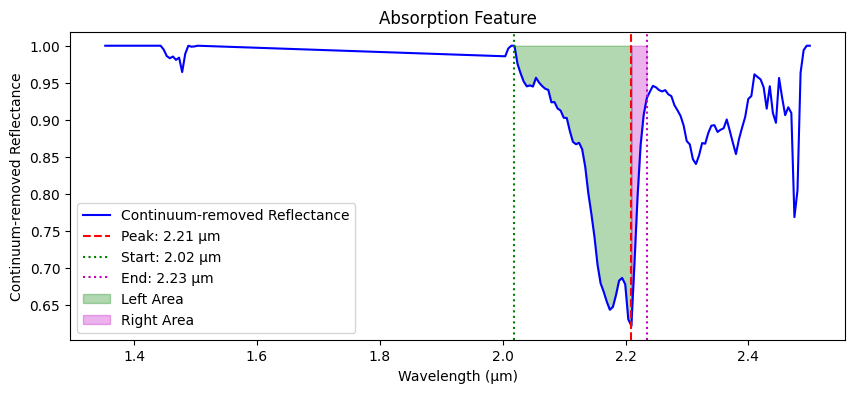


Extracted Features:
   peak_wavelength  width  depth  symmetry  area_ratio
0           2.2095 0.2154 0.3778    0.8837      6.7381


In [8]:
# Usage example:
features_df = extract_spectral_features('kaolinite_pixel.csv')
print("\nExtracted Features:")
print(features_df.to_string(float_format="%.4f"))

In [9]:
import pandas as pd
import joblib
import numpy as np

# 1. Load the pre-trained model
model_pkg = joblib.load('decision_tree.pkl')  # Load your .pkl file
model = model_pkg['model']
label_encoder = model_pkg['label_encoder']

required_features = model_pkg['features']  # All features the model expects
mineral_ranges = model_pkg['mineral_ranges']  # Range definitions used during training


# 2. Prepare your input DataFrame (features_df)
# Ensure these basic features exist in your input:
basic_features = ['peak_wavelength', 'width', 'depth', 'symmetry', 'area_ratio']
if not all(feat in features_df.columns for feat in basic_features):
    raise ValueError("Missing basic spectral features in input data")

# 3. Add the missing range-based features
# Create range-based features using known mineral characteristics
def create_range_features(row):
    features = {}
    
    # Alunite range features
    features['is_alunite_p_range'] = 1 if 2.165 <= row['peak_wavelength'] <= 2.195 else 0
    features['is_alunite_w_range'] = 1 if 0.2 <= row['width'] <= 0.25 else 0
    features['is_alunite_d_range'] = 1 if 0.25 <= row['depth'] <= 0.76 else 0
    features['is_alunite_as_range'] = 1 if 1.50 <= row['area_ratio'] <= 3.37 else 0
    features['is_alunite_sm_range'] = 1 if 0.73 <= row['symmetry'] <= 0.76 else 0
    
    
    # Kaolinite range features
    features['is_kaolinite_p_range'] = 1 if 2.203 <= row['peak_wavelength'] <= 2.210 else 0
    features['is_kaolinite_w_range'] = 1 if 0.14 <= row['width'] <= 0.22 else 0
    features['is_kaolinite_d_range'] = 1 if 0.15 <= row['depth'] <= 0.25 else 0
    features['is_kaolinite_as_range'] = 1 if 3.46 <= row['area_ratio'] <= 6.74 else 0
    features['is_kaolinite_sm_range'] = 1 if 0.63 <= row['symmetry'] <= 0.76 else 0
    

    # Montmorillonite range features
    features['is_montmorillonite_p_range'] = 1 if 2.205 <= row['peak_wavelength'] <= 2.220 else 0
    features['is_montmorillonite_w_range'] = 1 if 0.1 <= row['width'] <= 0.16 else 0
    features['is_montmorillonite_d_range'] = 1 if 0.01 <= row['depth'] <= 0.15 else 0
    features['is_montmorillonite_as_range'] = 1 if 0.37 <= row['area_ratio'] <= 1.47 else 0
    features['is_montmorillonite_sm_range'] = 1 if 0.31 <= row['symmetry'] <= 0.52 else 0
    
    return pd.Series(features)


In [10]:
required_features

['peak_wavelength',
 'width',
 'depth',
 'symmetry',
 'area_ratio',
 'is_alunite_p_range',
 'is_alunite_w_range',
 'is_alunite_d_range',
 'is_alunite_as_range',
 'is_alunite_sm_range',
 'is_kaolinite_p_range',
 'is_kaolinite_w_range',
 'is_kaolinite_d_range',
 'is_kaolinite_as_range',
 'is_kaolinite_sm_range',
 'is_montmorillonite_p_range',
 'is_montmorillonite_w_range',
 'is_montmorillonite_d_range',
 'is_montmorillonite_as_range',
 'is_montmorillonite_sm_range']

In [11]:
range_features = features_df.apply(create_range_features, axis=1)
features_df = pd.concat([features_df, range_features], axis=1)
features_df

,peak_wavelength,width,depth,symmetry,area_ratio,is_alunite_p_range,is_alunite_w_range,is_alunite_d_range,is_alunite_as_range,is_alunite_sm_range,is_kaolinite_p_range,is_kaolinite_w_range,is_kaolinite_d_range,is_kaolinite_as_range,is_kaolinite_sm_range,is_montmorillonite_p_range,is_montmorillonite_w_range,is_montmorillonite_d_range,is_montmorillonite_as_range,is_montmorillonite_sm_range
0,2.209525,0.215373,0.377769,0.883721,6.738089,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0


In [12]:
features_df.to_csv('pixel_features.csv', index=False)
print("DataFrame successfully saved to pixel_features.csv") 

DataFrame successfully saved to pixel_features.csv


In [13]:
try:
    test_data = pd.read_csv('pixel_features.csv')
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()


In [14]:
X_test_pixel = test_data[required_features]

In [15]:
y_pred_encoded = model.predict(X_test_pixel)
y_pred_pixel = label_encoder.inverse_transform(y_pred_encoded)
test_data['predicted_mineral'] = y_pred_pixel

In [16]:
print("\nSample Predictions:")
print(test_data[['peak_wavelength', 'width', 'depth','area_ratio','symmetry','predicted_mineral']].head())


Sample Predictions:
   peak_wavelength     width     depth  area_ratio  symmetry predicted_mineral
0         2.209525  0.215373  0.377769    6.738089  0.883721         kaolinite


In [17]:
def calculate_depth_at_wavelength(spectrum_wavelength, spectrum_reflectance, target_wavelength, tolerance=0.01):
    """
    Calculate the depth at a specific wavelength in the illite spectrum.
    :param illite_wavelengths: Array of wavelengths in the illite spectrum.
    :param illite_reflectance: Array of reflectance values in the illite spectrum.
    :param target_wavelength: Target wavelength to find the depth.
    :param tolerance: Tolerance for wavelength approximation.
    :return: Depth at the target wavelength.
    """
    # Find the index of the closest wavelength
    idx = np.argmin(np.abs(spectrum_wavelength - target_wavelength))
    
    # Check if the closest wavelength is within the tolerance
    if np.abs(spectrum_wavelength[idx] - target_wavelength) <= tolerance:
        # Calculate depth as the difference between the continuum and the reflectance
        depth = 1 - spectrum_reflectance[idx]  # Assuming continuum-removed reflectance
        return depth
    else:
        return None

In [18]:
# Calculate depth ratio for illite predictions
for i, pred in enumerate(y_pred_pixel):
    
    if pred == 'kaolinite':
        # Get the peak wavelength from the pixel signature
        peak_wavelength = features_df.loc[i, 'peak_wavelength']
        
        # Calculate the depth at the peak wavelength in the average kaolinite spectrum
        kaolinite_depth = calculate_depth_at_wavelength(
            kaolinite_data['wavelength'],
            kaolinite_data['average_reflectance'],
            peak_wavelength
        )
        
        if kaolinite_depth is not None:
            # Get the depth from the pixel signature
            pixel_depth = features_df.loc[i, 'depth']
            
            # Calculate the ratio of depths
            depth_ratio = kaolinite_depth/pixel_depth
            test_data.at[i, 'depth_ratio'] = depth_ratio
        else:
            test_data.at[i, 'depth_ratio'] = "No matching wavelength"
    
    else:
        test_data.at[i, 'depth_ratio'] = "Not available"
        
        

# Print the updated DataFrame
print("\nPixel Signatures:")
print(test_data[['peak_wavelength', 'predicted_mineral', 'depth_ratio']])


Pixel Signatures:
   peak_wavelength predicted_mineral  depth_ratio
0         2.209525         kaolinite     0.496718
